In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm

import pandas as pd
import patsy as pt
import numpy as np

import theano.tensor as tt

## Custom find_MAP

In [23]:
from pymc3.model import modelcontext, Point, ValueGradFunction
from pymc3.blocking import ArrayOrdering, DictToArrayBijection
from pymc3.theanof import inputvars, floatX
from pymc3.util import update_start_vals
from scipy.optimize import minimize
from tqdm import tqdm

In [10]:
def find_MAP(start=None, vars=None, fmin=None, return_raw=False, model=None, callback=None, *args, **theano_kwargs):
    model = modelcontext(model)
    if start is None:
        start = model.test_point
    else:
        update_start_vals(start, model.test_point, model)
        
    if not set(start.keys()).issubset(model.named_vars.keys()):
        extra_keys = ', '.join(set(start.keys()) - set(model.named_vars.keys()))
        valid_keys = ', '.join(model.named_vars.keys())
        raise KeyError('Some start parameters do not appear in the model!\n'
                       'Valid keys are: {}, but {} was supplied'.format(valid_keys, extra_keys))

    if vars is None:
        vars = model.cont_vars
    vars = inputvars(vars)
    
    ## checking for discrete variables here, or unavailable gradient, setting default optimizers...
    
    start = Point(start, model=model)
    bij = DictToArrayBijection(ArrayOrdering(vars), start)
    x0 = bij.map(start) 
 
    class OptWrapper(object):
        # to record a trace of the optimization, check lines 920 to 935 of opvi.py
        #   grep for "include_transformed"
        def __init__(self, logp_dlogp_func, maxiter):
            logp_dlogp_func
            self._num_calls = 0
            self._logp_dlogp_func = logp_dlogp_func
            self._previous_x = None
            self._maxiter = maxiter
            self.progress = tqdm(total=maxiter)
  
        def __call__(self, x):
            logp, dlogp = self._logp_dlogp_func(pm.floatX(x))
            # replace nans and infs with zero in gradient
            finite = np.isfinite(dlogp)
            if all(finite):
                # cache good value of x
                self._previous_x = x
            else:
                dlogp = np.where(finite, dlogp, 0.0)
            
            # convert to numpy float64 (rename logp before this to neg_logp)
            logp = np.float64(-1.0 * logp)
            dlogp = np.float64(-1.0 * dlogp)
            
            self._num_calls += 1
            self.progress.update(1)
            if self._num_calls % 10 == 0:
                grad = np.linalg.norm(dlogp)
                desc = 'lp = {:,.5g}, ||grad|| = {:,.5g}'.format(-1.0*logp, grad)
                self.progress.set_description(desc)
            if self._num_calls > self._maxiter:
                grad = np.linalg.norm(dlogp)
                desc = 'lp = {:,.5g}, ||grad|| = {:,.5g}'.format(-1.0*logp, grad)
                self.progress.set_description(desc)
                self.progress.close()
                raise KeyboardInterrupt
            return logp, dlogp 
         
    method = 'L-BFGS-B'
    tol = None
    callback = None
    maxiter = 1000
           
    #running the optimization
    logp_dlogp_func = model.logp_dlogp_function(vars, dtype=None, **theano_kwargs)
    logp_dlogp_func.set_extra_values(start)
    x0 = logp_dlogp_func.dict_to_array(start)
    
    
    objective = OptWrapper(logp_dlogp_func, maxiter)
    try:
        result = minimize(fun=objective,
                          x0=x0,
                          method=method,
                          jac=True,
                          options={"disp": True})
    except KeyboardInterrupt:
        print("Caught KeyboardInterrupt, setting \
              model with most recent state.")
        objective.set_state(obj._previous_x)
        objective.progress.close()
        return None
    objective.progress.close() 
   
    point = logp_dlogp_func.array_to_dict(pm.floatX(result["x"]))
    
    # pulled the following out of the trace lib
    vars = model.unobserved_RVs
    varnames = [var.name for var in model.unobserved_RVs]
    fn = model.fastfn(vars)
    start = {}
    for varname, value in zip(varnames, fn(point)): 
        start[varname] = value
    return start

## actual analysis

In [4]:
data_monthly = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)

# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
data_monthly.columns = cols
cols.remove("--"); cols.remove("--")
data_monthly = data_monthly[cols]

# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year"); cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.head(5)

CO2  seasonaly_adjusted     fit  seasonally_adjusted_fit  \
1958-03-15  315.69              314.43  316.18                   314.90   
1958-04-15  317.46              315.15  317.30                   314.98   
1958-05-15  317.50              314.73  317.84                   315.06   
1958-07-15  315.86              315.17  315.87                   315.22   
1958-08-15  314.93              316.17  314.01                   315.29   

            CO2_filled  seasonally_adjusted_filled  
1958-03-15      315.69                      314.43  
1958-04-15      317.46                      315.15  
1958-05-15      317.50                      314.73  
1958-07-15      315.86                      315.17  
1958-08-15      314.93                      316.17

In [5]:
reference_time = pd.to_datetime('1958-03-15')
d = data_monthly.index - reference_time
t = d / pd.Timedelta(1, "Y")

## normalize co2 reading levels
y = data_monthly["CO2"].values
mean_co2 = np.mean(y)
std_co2 = np.std(y)
y_n = (y - mean_co2) / std_co2

data_monthly = data_monthly.assign(t = t)
data_monthly = data_monthly.assign(y_n = y_n)
data_monthly.head(5)

CO2  seasonaly_adjusted     fit  seasonally_adjusted_fit  \
1958-03-15  315.69              314.43  316.18                   314.90   
1958-04-15  317.46              315.15  317.30                   314.98   
1958-05-15  317.50              314.73  317.84                   315.06   
1958-07-15  315.86              315.17  315.87                   315.22   
1958-08-15  314.93              316.17  314.01                   315.29   

            CO2_filled  seasonally_adjusted_filled         t       y_n  
1958-03-15      315.69                      314.43  0.000000 -1.396994  
1958-04-15      317.46                      315.15  0.084875 -1.330174  
1958-05-15      317.50                      314.73  0.167012 -1.328663  
1958-07-15      315.86                      315.17  0.334025 -1.390576  
1958-08-15      314.93                      316.17  0.418900 -1.425686

In [6]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))
data_prior = data_monthly.iloc[:sep_idx+1, :]
data_after = data_monthly.iloc[sep_idx:, :]

In [7]:
# make plot
from bokeh.plotting import figure, show
from bokeh.models import BoxAnnotation, Span
from bokeh.io import output_notebook

output_notebook()
p = figure(x_axis_type='datetime', title='Monthly CO2 Readings from Mauna Loa',
           plot_width=700, plot_height=300)
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

p.line(data_monthly.index, data_monthly['CO2'], 
       line_width=1, line_color="black", alpha=0.5)
p.circle(data_monthly.index, data_monthly['CO2'], 
         line_color="black", alpha=0.1, size=1)

predict_region = BoxAnnotation(left=pd.to_datetime("2003-12-15"), 
                               fill_alpha=0.1, fill_color='navy')
ppm400 = Span(location=400,
              dimension='width', line_color='red',
              line_dash='dashed', line_width=1)
p.add_layout(predict_region)
p.add_layout(ppm400)

show(p)

Loading BokehJS ...

## Build model

In [8]:
# Build model
n1 = len(data_prior)
n2 = len(data_after)
y_n = data_prior["y_n"].values

X = np.concatenate((np.ones((n1,1)), data_prior["t"].values[:,None]),1)
# initialize linear fit
β_init = np.linalg.lstsq(X, y_n)[0]
print(β_init)

[-1.61115985  0.05137085]


In [11]:
with pm.Model() as model:
    PosNormal = pm.Bound(pm.Normal, lower=0.0)
    
with model:
    # yearly periodic component x long term trend
    # if l1 is long, then periodic component decays slowly
    η1 = pm.HalfCauchy("η1", beta=5, testval=1.0)
    ℓ1 = pm.Gamma("ℓ1", alpha=3, beta=0.025, testval=75)
    p  = PosNormal("p", mu=1, sd=0.1, testval=1.0)
    # lp centered around p
    ℓp = pm.Gamma("ℓp", alpha=2, beta=2, testval=1.0)
    cov_seasonal = tt.square(η1) * pm.gp.cov.Periodic(2, ℓp, p, active_dims=[1]) \
                                 * pm.gp.cov.Matern52(2, ℓ1, active_dims=[1])
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    # small/medium term irregularities
    η2 = pm.HalfCauchy("η2", beta=5, testval=1.0)
    ℓ2 = pm.Gamma("ℓ2", alpha=1.1, beta=0.2, testval=5.0)
    ##α = pm.HalfStudentT("α", mu=1.0, lam=1.0, nu=4)
    #α = pm.Gamma("α", alpha=1.1, beta=0.1, testval=2) # start with some diffusivity
    cov_medium = tt.square(η2) * pm.gp.cov.ExpQuad(2, ℓ2, active_dims=[1])
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
    
    # long term trend
    η3 = pm.HalfCauchy("η3", beta=5, testval=1.0)
    ℓ3 = pm.Gamma("ℓ3", alpha=3, beta=0.1, testval=30.0)
    cov_trend = tt.square(η3) * pm.gp.cov.ExpQuad(2, ℓ3, active_dims=[1])
   
    # positive trend, linear mean function
    β = pm.Normal("β", mu=0.0, sd=10, shape=2, testval=β_init)
    mean = pm.gp.mean.Linear(β)
    gp_trend = pm.gp.Marginal(mean, cov_trend)   

    # noise model
    ηn = pm.HalfNormal("ηn", sd=1, testval=0.1)
    ℓn = pm.Gamma("ℓn", alpha=1.05, beta=3, testval=0.05)
    σ  = pm.HalfNormal("σ",  sd=1, testval=0.05)
    cov_noise = tt.square(ηn) * pm.gp.cov.Matern52(2, ℓn, active_dims=[1]) +\
                pm.gp.cov.WhiteNoise(σ)
    
    gp = gp_seasonal + gp_medium + gp_trend
    
    #mu = mean(X)
    #K = cov(X) + covn(X)
    #L = tt.slinalg.cholesky(K)
    #gp = pm.MvNormal("gp", mu=mu, chol=L, observed=yn)
    y_ = gp.prior("y_", n_points=X.shape[0], X=X, y=y_n, noise=cov_noise)
    #gp = pm.gp.GP("gp", X, cov_func=cov, cov_func_noise=covn, 
    #              mean_func=mean, observed=yn)
    #start = pm.find_MAP(live_disp=True, fmin=sp.optimize.fmin_l_bfgs_b)
    #tr = pm.sample(1000, init='map')
    #tr = pm.fit(50000, method='fullrank_advi').sample(10000)
    start = find_MAP()

lp = 1,648.4, ||grad|| = 110.42:  69%|██████▉   | 690/1000 [01:54<00:53,  5.76it/s] 


In [12]:
start

{'p': array(0.9997228384017944, dtype=float32),
 'p_lowerbound__': array(-0.0002772181178443134, dtype=float32),
 'β': array([-0.99044657,  0.04354252], dtype=float32),
 'η1': array(0.11798261106014252, dtype=float32),
 'η1_log__': array(-2.1372179985046387, dtype=float32),
 'η2': array(0.022466234862804413, dtype=float32),
 'η2_log__': array(-3.7957417964935303, dtype=float32),
 'η3': array(0.5675079226493835, dtype=float32),
 'η3_log__': array(-0.5665006041526794, dtype=float32),
 'ηn': array(0.007781555876135826, dtype=float32),
 'ηn_log__': array(-4.855998992919922, dtype=float32),
 'σ': array(0.006936319638043642, dtype=float32),
 'σ_log__': array(-4.970983982086182, dtype=float32),
 'ℓ1': array(141.26853942871094, dtype=float32),
 'ℓ1_log__': array(4.950662612915039, dtype=float32),
 'ℓ2': array(1.0333073139190674, dtype=float32),
 'ℓ2_log__': array(0.032764676958322525, dtype=float32),
 'ℓ3': array(34.627342224121094, dtype=float32),
 'ℓ3_log__': array(3.5446436405181885, dtype=

In [19]:
model.cont_vars

[η1_log__,
 ℓ1_log__,
 p_lowerbound__,
 ℓp_log__,
 η2_log__,
 ℓ2_log__,
 η3_log__,
 ℓ3_log__,
 β,
 ηn_log__,
 ℓn_log__,
 σ_log__]

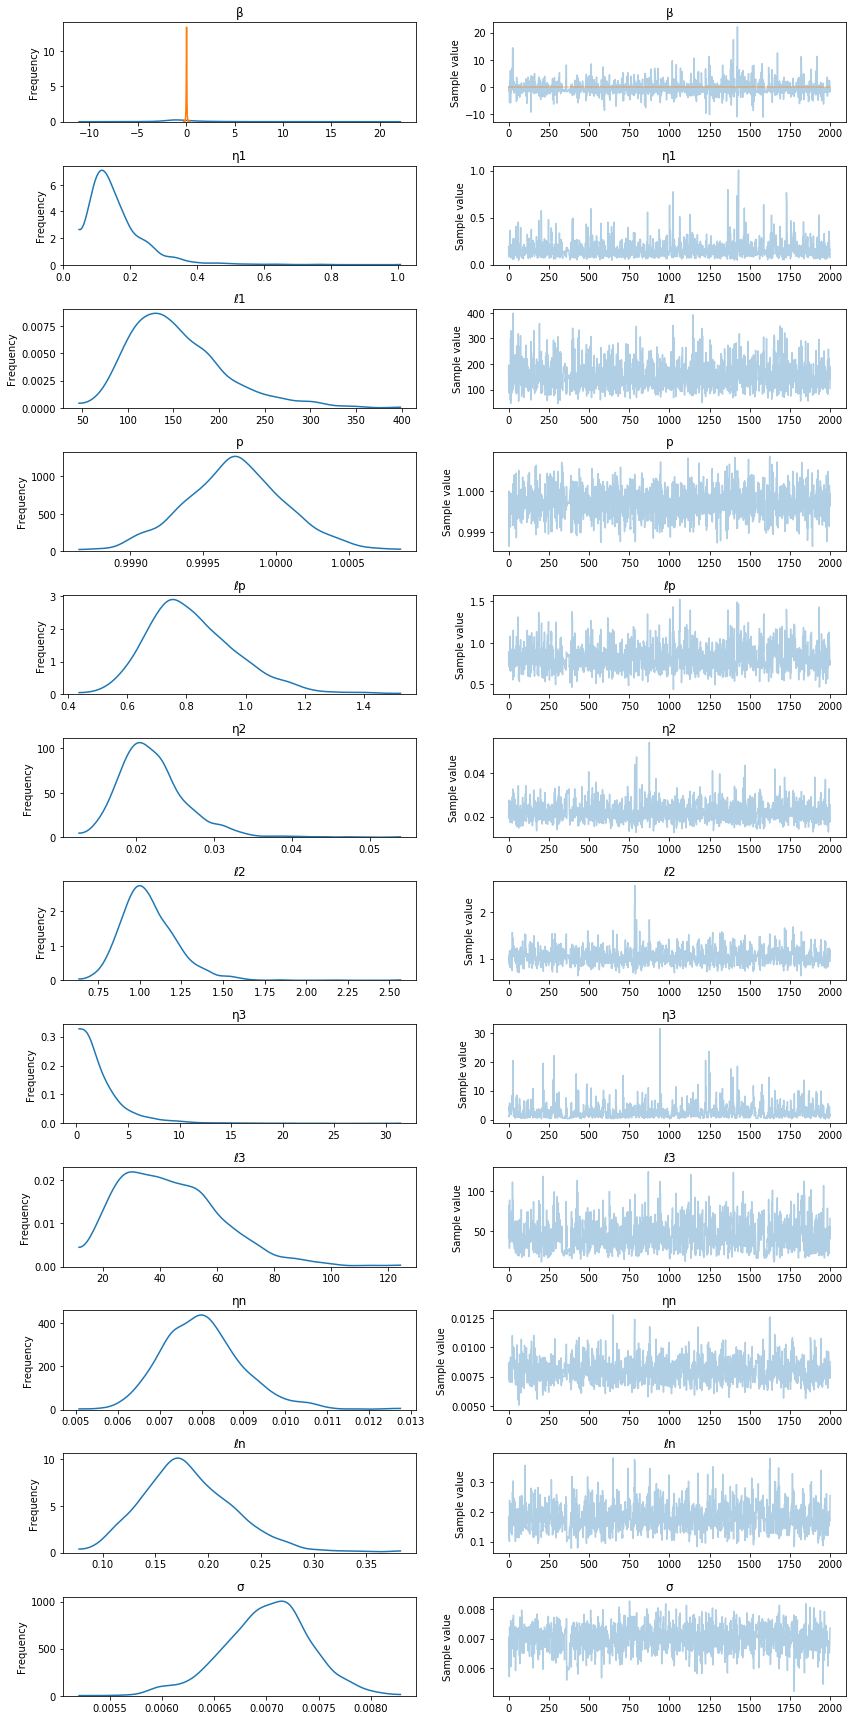

In [10]:
%matplotlib inline
pm.traceplot(tr);

In [11]:
# predict total
n = len(data_monthly)
Xnew = np.concatenate((np.ones((n, 1)), data_monthly["t"].values[:,None]),1)

n_draws = 100
with model:
    f_pred = gp.conditional("f_pred", n_points=n, Xnew=Xnew)
    samples = pm.sample_ppc(tr, vars=[f_pred], samples=n_draws)

100%|██████████| 100/100 [00:44<00:00,  2.32it/s]


In [12]:
preds = samples[f_pred.name]*std_co2 + mean_co2

## make plot
p = figure(x_axis_type='datetime', plot_width=700, plot_height=300)

# previous plot
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

p.line(data_monthly.index, data_monthly['CO2'], 
       line_width=1, line_color="black")

predict_region = BoxAnnotation(left=pd.to_datetime("2003-12-15"), 
                               fill_alpha=0.1, fill_color='firebrick')
ppm400 = Span(location=400,
              dimension='width', line_color='black',
              line_dash='dashed', line_width=1)
p.add_layout(predict_region)
p.add_layout(ppm400)

# predictions
p.multi_line([data_monthly.index]*n_draws, [preds[i,:] for i in range(n_draws)],
             color="green", alpha=0.05)
show(p)



In [15]:
with model:
    f_seasonal = gp_seasonal.conditional("f_seasonal1", n_points=n, 
                                         Xnew=Xnew, X=X, y=y_n, cov_func_noise=cov_noise)
    samples = pm.sample_ppc(tr, vars=[f_seasonal], samples=n_draws)

100%|██████████| 100/100 [00:35<00:00,  2.94it/s]


In [16]:
preds = samples[f_seasonal.name]*std_co2 + mean_co2

preds_deseason = [data_monthly["CO2"].values - preds[i,:] for i in range(n_draws)]

## make plot
p = figure(x_axis_type='datetime', plot_width=700, plot_height=300)

# previous plot
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

#p.line(data_prior.index, data_prior['CO2'], 
#       line_width=1, line_color="black")
#p.line(data_after.index, data_after['CO2'], 
#       line_width=1, line_color="black", alpha=0.5)

predict_region = BoxAnnotation(left=pd.to_datetime("2003-12-15"), 
                               fill_alpha=0.1, fill_color='firebrick')
#ppm400 = Span(location=400,
#              dimension='width', line_color='black',
#              line_dash='dashed', line_width=1)
p.add_layout(predict_region)
#p.add_layout(ppm400)

# predictions
p.multi_line([data_monthly.index]*n_draws, [preds_deseason[i] for i in range(n_draws)],
             color="green", alpha=0.05)
show(p)

In [17]:
with model:
    f_medium = gp_medium.conditional("f_medium", n_points=n,
                                     Xnew=Xnew, X=X, y=y_n, cov_func_noise=cov_noise)
    samples = pm.sample_ppc(tr, vars=[f_medium], samples=n_draws)

100%|██████████| 100/100 [00:33<00:00,  3.24it/s]


In [18]:
preds = samples[f_medium.name]*std_co2 + mean_co2

## make plot
p = figure(x_axis_type='datetime', plot_width=700, plot_height=300)

# previous plot
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

predict_region = BoxAnnotation(left=pd.to_datetime("2003-12-15"), 
                               fill_alpha=0.1, fill_color='firebrick')
#ppm400 = Span(location=400,
#              dimension='width', line_color='black',
#              line_dash='dashed', line_width=1)
p.add_layout(predict_region)
#p.add_layout(ppm400)

# predictions
p.multi_line([data_monthly.index]*n_draws, [preds[i,:] for i in range(n_draws)],
             color="green", alpha=0.05)
show(p)

In [19]:
with model:
    f_trend = gp_trend.conditional("f_trend", n_points=n,
                                   Xnew=Xnew, X=X, y=y_n, cov_func_noise=cov_noise) 
    samples = pm.sample_ppc(tr, vars=[f_trend], samples=n_draws)

100%|██████████| 100/100 [00:30<00:00,  3.49it/s]


In [20]:
preds = samples[f_trend.name]*std_co2 + mean_co2

## make plot
p = figure(x_axis_type='datetime', plot_width=700, plot_height=300)

# previous plot
p.yaxis.axis_label = 'CO2 [ppm]'
p.xaxis.axis_label = 'Date'

p.line(data_monthly.index, data_monthly['CO2'], 
       line_width=1, line_color="black")

predict_region = BoxAnnotation(left=pd.to_datetime("2003-12-15"), 
                               fill_alpha=0.1, fill_color='firebrick')
#ppm400 = Span(location=400,
#              dimension='width', line_color='black',
#              line_dash='dashed', line_width=1)
p.add_layout(predict_region)
#p.add_layout(ppm400)

# predictions
p.multi_line([data_monthly.index]*n_draws, [preds[i,:] for i in range(n_draws)],
             color="green", alpha=0.05)
show(p)